----
# EXERCISE 2:  CART-POLE
----

### 2.1 MDP definition

**State space**
`s = (x, x_dot, theta, theta_dot)`
- `x`: position of the cart
- `x_dot`: velocity of the cart
- `theta`: angle of the pole
- `theta_dot`: angular velocity of the pole

**Action space**
a = {-1, 0, 1}
- -1: negative force
- 0: no force
- 1: positive force


In [428]:
import numpy as np
import matplotlib.pyplot as plt

M_CART = 1.0      # kg
M_POLE = 0.1      # kg
L_POLE = 0.5      # m
G = 9.8           # m/s^2
F_APPLIED = 2.0  # N

X_THRESH = 2.4                  # m
THETA_THRESH = 15 * np.pi / 180 # rad

DELTA_T = 0.1  # s

gamma = 0.99

In [424]:
def simulate(s, a, delta_t=DELTA_T):

    x, x_dot, theta, theta_dot = s

    if abs(x) > X_THRESH or abs(theta) > THETA_THRESH:
        r = 0
        return (x, x_dot, theta, theta_dot), r
    
    if a == -1:
        F = -F_APPLIED
    elif a == 0:
        F = 0
    elif a == 1:
        F = F_APPLIED

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    tau = (F + theta_dot**2 * L_POLE * sin_theta/2) / (M_CART + M_POLE)
    alpha = (G * sin_theta - tau * cos_theta) / ((L_POLE/2) * (4/3 - M_POLE * cos_theta**2 / (M_CART + M_POLE)))

    accel = tau - L_POLE/2 * alpha * cos_theta * M_POLE / (M_CART + M_POLE)

    x_new = x + delta_t * x_dot
    x_dot_new = x_dot + delta_t * accel
    theta_new = theta + delta_t * theta_dot
    theta_dot_new = theta_dot + delta_t * alpha
    r = 1

    return (x_new, x_dot_new, theta_new, theta_dot_new), r

### 2.2. Utils

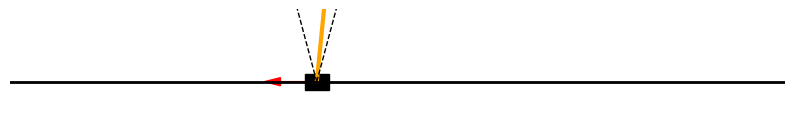

In [425]:
from matplotlib import patches

def show_cart_pole(s, a=None, ax=None):
    CART_SIZE = (0.15, 0.1)
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10,5))

    x, _, theta, _ = s

    cart_x = x
    cart_y = 0.1
    pole_x = x + L_POLE * np.sin(theta)
    pole_y = 0.1 + L_POLE * np.cos(theta)

    ax.plot([cart_x, pole_x], [cart_y, pole_y], color='orange', linewidth=3)
    ax.add_patch(patches.Rectangle((cart_x-CART_SIZE[0]/2, cart_y-CART_SIZE[1]/2), CART_SIZE[0], CART_SIZE[1], color='black'))

    ax.plot([-X_THRESH, X_THRESH], [0.1, 0.1], color='black', linewidth=2)

    ax.plot([cart_x, cart_x + L_POLE * np.sin(THETA_THRESH)], [cart_y, cart_y + L_POLE * np.cos(THETA_THRESH)], '--k', linewidth=1)
    ax.plot([cart_x, cart_x + L_POLE * np.sin(-THETA_THRESH)], [cart_y, cart_y + L_POLE * np.cos(-THETA_THRESH)], '--k', linewidth=1)
    
    if a is not None:
        if a == -1:
            ax.arrow(cart_x - CART_SIZE[0]/2, cart_y , -0.15, 0, head_width=0.05, head_length=0.1, fc='r', ec='r')
        elif a == 1:
            ax.arrow(cart_x + CART_SIZE[0]/2, cart_y , 0.15, 0, head_width=0.05, head_length=0.1, fc='r', ec='r')

    ax.set_xlim([-X_THRESH, X_THRESH])
    ax.set_ylim([-0.1, 1.1*L_POLE])
    ax.set_aspect('equal')
    ax.axis('off')
    
    return ax

s = (-0.5, 0.0, 0.1, 0.0)
show_cart_pole(s, -1);

(0.18469417789091552, 0.9303778098778257, 0.025475310696681054, -0.8935032463712392)
5


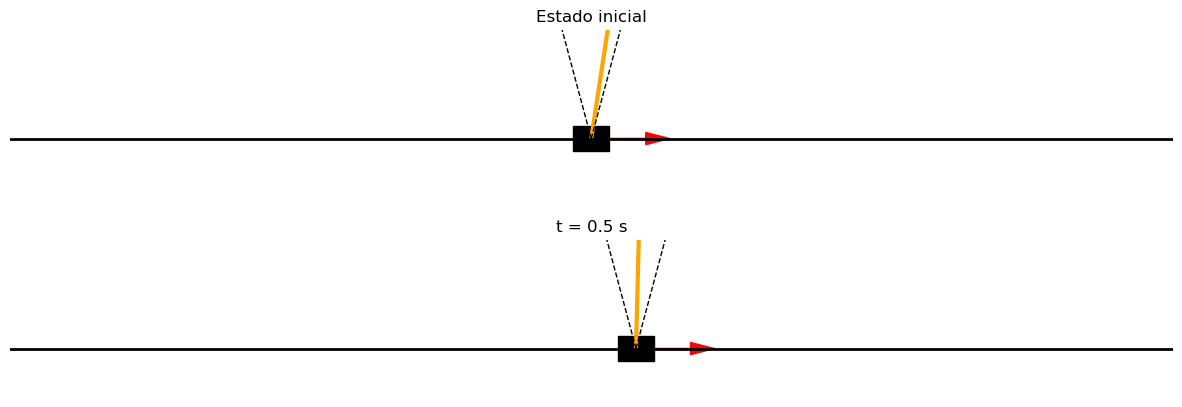

In [434]:
s_inicial = (0.0, 0.0, 0.15, 0.0)
a = 1

s = s_inicial
rs = 0
for i in range(5):
    s, r = simulate(s, a)
    rs += r

fig, axs = plt.subplots(2,1, figsize=(15,5))
show_cart_pole(s_inicial,ax = axs[0], a=a)
show_cart_pole(s,ax = axs[1], a=a);

axs[0].set_title('Estado inicial')
axs[1].set_title('t = 0.5 s')
print(s)
print(rs)

(-0.18469417789091552, -0.9303778098778257, -0.025475310696681054, 0.8935032463712392)
5


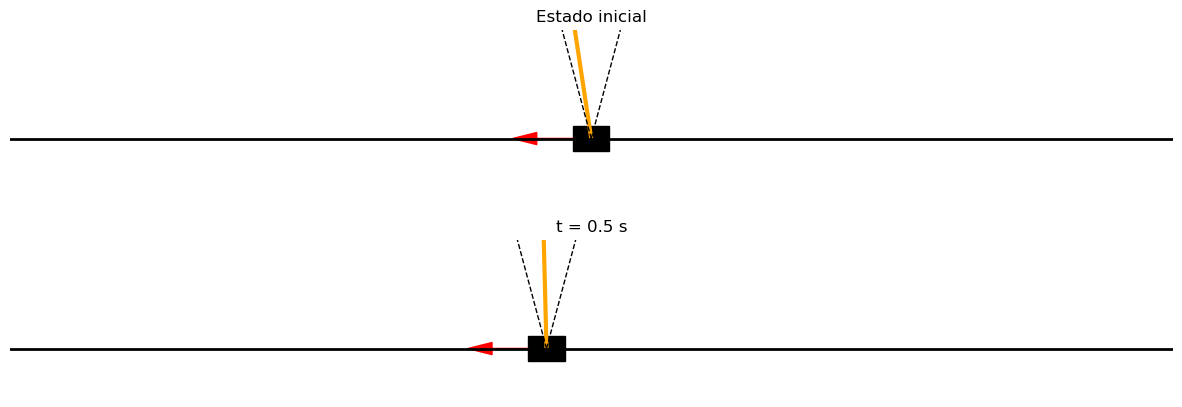

In [436]:
s_inicial = (0.0, 0.0, -0.15, 0.0)
a = -1

s = s_inicial
rs = 0
for i in range(5):
    s, r = simulate(s, a)
    rs += r

fig, axs = plt.subplots(2,1, figsize=(15,5))
show_cart_pole(s_inicial,ax = axs[0], a=a)
show_cart_pole(s,ax = axs[1], a=a);

axs[0].set_title('Estado inicial')
axs[1].set_title('t = 0.5 s')

print(s)
print(rs)

### 2.3. Resolution

##### 2.3.1. Aprox Value Iteration

**Discretization**

i -> x ; j -> x_dot ; k -> theta ; l -> theta_dot

State s = (x, x_dot, theta, theta_dot):

ind = i + j*RES + k*RES^2 + l*RES^3 ; i, j, k, l = 0, ..., RES-1


In [437]:
RES = 5
x_values = np.linspace(-X_THRESH - 0.1, X_THRESH + 0.1, RES)
x_dot_values = np.linspace(-2.0, 2.0, RES)
theta_values = np.linspace(-THETA_THRESH - 0.1, THETA_THRESH + 0.1, RES)
theta_dot_values = np.linspace(-2.0, 2.0, RES)

n_states = RES**4
print('Número de estados discretizados: {}'.format(n_states))
n_actions = 3

T = np.zeros((n_states, n_actions, n_states))
R = np.zeros((n_states, n_actions, n_states))
for i, x in enumerate(x_values):
    for j, x_dot in enumerate(x_dot_values):
        for k, theta in enumerate(theta_values):
            for l, theta_dot in enumerate(theta_dot_values):

                s = (x, x_dot, theta, theta_dot)
                
                for a in range(n_actions):
                    s_new, r = simulate(s, a-1)
                    x_new, x_dot_new, theta_new, theta_dot_new = s_new

                    i_new = np.argmin(np.abs(x_values - x_new))
                    j_new = np.argmin(np.abs(x_dot_values - x_dot_new))
                    k_new = np.argmin(np.abs(theta_values - theta_new))
                    l_new = np.argmin(np.abs(theta_dot_values - theta_dot_new))
                                       
                    T[i + j*RES + k*RES**2 + l*RES**3, a, i_new + j_new*RES + k_new*RES**2 + l_new*RES**3] = 1
                    R[i + j*RES + k*RES**2 + l*RES**3, a, :] = r                  


Número de estados discretizados: 625


In [438]:
Tsum = np.round(np.sum(T, axis=2), 2)
print(Tsum[Tsum != 1]) # Fast check that all transitions per state sum to 1

[]


In [439]:
def look_ahead(T, R, gamma, U, s, a):
    return  np.sum([T[s,a,sp]*(R[s,a,sp] + gamma*U[sp]) for sp in range(n_states)])

def backup(T, R, gamma, U, s):
    return np.max([look_ahead(T, R, gamma, U, s, a) for a in range(n_actions)])

def async_iterative_value_iteration(T, R, gamma, U_initial, k_max=100):
    U = U_initial.copy()
    for k in range(k_max):
        for s in range(n_states):
            U[s] = backup(T, R, gamma, U, s)
    return U

U_initial = (np.random.rand(n_states) - 0.5) / 10
params = async_iterative_value_iteration(T, R, gamma, U_initial, k_max=100)

In [440]:
np.savetxt('params.csv', params, delimiter=',')
# params = np.loadtxt('U_vi.csv', delimiter=',')

In [404]:
# Multilineal Interpolation for 4D
def U_parametrized_4d(s, params):
    x, x_dot, theta, theta_dot = s
    
    i1 = np.digitize(x, x_values) - 1
    x1 = x_values[i1]
    i2 = np.digitize(x, x_values)
    x2 = x_values[i2]

    j1 = np.digitize(x_dot, x_dot_values) - 1
    x_dot1 = x_dot_values[j1]
    j2 = np.digitize(x_dot, x_dot_values)
    x_dot2 = x_dot_values[j2]

    k1 = np.digitize(theta, theta_values) - 1
    theta1 = theta_values[k1]
    k2 = np.digitize(theta, theta_values)
    theta2 = theta_values[k2]

    l1 = np.digitize(theta_dot, theta_dot_values) - 1
    theta_dot1 = theta_dot_values[l1]
    l2 = np.digitize(theta_dot, theta_dot_values)
    theta_dot2 = theta_dot_values[l2]

    u1111 = params[i1 + j1*RES + k1*RES**2 + l1*RES**3]
    u2111 = params[i2 + j1*RES + k1*RES**2 + l1*RES**3]
    u1211 = params[i1 + j2*RES + k1*RES**2 + l1*RES**3]
    u2211 = params[i2 + j2*RES + k1*RES**2 + l1*RES**3]
    u1121 = params[i1 + j1*RES + k2*RES**2 + l1*RES**3]
    u2121 = params[i2 + j1*RES + k2*RES**2 + l1*RES**3]
    u1221 = params[i1 + j2*RES + k2*RES**2 + l1*RES**3]
    u2221 = params[i2 + j2*RES + k2*RES**2 + l1*RES**3]
    u1112 = params[i1 + j1*RES + k1*RES**2 + l2*RES**3]
    u2112 = params[i2 + j1*RES + k1*RES**2 + l2*RES**3]
    u1212 = params[i1 + j2*RES + k1*RES**2 + l2*RES**3]
    u2212 = params[i2 + j2*RES + k1*RES**2 + l2*RES**3]
    u1122 = params[i1 + j1*RES + k2*RES**2 + l2*RES**3]
    u2122 = params[i2 + j1*RES + k2*RES**2 + l2*RES**3]
    u1222 = params[i1 + j2*RES + k2*RES**2 + l2*RES**3]
    u2222 = params[i2 + j2*RES + k2*RES**2 + l2*RES**3]

    u = (u1111 * (x2 - x) * (x_dot2 - x_dot) * (theta2 - theta) * (theta_dot2 - theta_dot) +
         u2111 * (x - x1) * (x_dot2 - x_dot) * (theta2 - theta) * (theta_dot2 - theta_dot) +
         u1211 * (x2 - x) * (x_dot - x_dot1) * (theta2 - theta) * (theta_dot2 - theta_dot) +
         u2211 * (x - x1) * (x_dot - x_dot1) * (theta2 - theta) * (theta_dot2 - theta_dot) +
         u1121 * (x2 - x) * (x_dot2 - x_dot) * (theta - theta1) * (theta_dot2 - theta_dot) +
         u2121 * (x - x1) * (x_dot2 - x_dot) * (theta - theta1) * (theta_dot2 - theta_dot) +
         u1221 * (x2 - x) * (x_dot - x_dot1) * (theta - theta1) * (theta_dot2 - theta_dot) +
         u2221 * (x - x1) * (x_dot - x_dot1) * (theta - theta1) * (theta_dot2 - theta_dot) +
         u1112 * (x2 - x) * (x_dot2 - x_dot) * (theta2 - theta) * (theta_dot - theta_dot1) +
         u2112 * (x - x1) * (x_dot2 - x_dot) * (theta2 - theta) * (theta_dot - theta_dot1) +
         u1212 * (x2 - x) * (x_dot - x_dot1) * (theta2 - theta) * (theta_dot - theta_dot1) +
         u2212 * (x - x1) * (x_dot - x_dot1) * (theta2 - theta) * (theta_dot - theta_dot1) +
         u1122 * (x2 - x) * (x_dot2 - x_dot) * (theta - theta1) * (theta_dot - theta_dot1) +
         u2122 * (x - x1) * (x_dot2 - x_dot) * (theta - theta1) * (theta_dot - theta_dot1) +
         u1222 * (x2 - x) * (x_dot - x_dot1) * (theta - theta1) * (theta_dot - theta_dot1) +
         u2222 * (x - x1) * (x_dot - x_dot1) * (theta - theta1) * (theta_dot - theta_dot1)) / ((x2 - x1) * (x_dot2 - x_dot1) * (theta2 - theta1) * (theta_dot2 - theta_dot1))

    return u

In [405]:
values = [x_values, x_dot_values, theta_values, theta_dot_values]

# Multilineal interpolation generalized to n dimensions
def U_parametrized_general(s, params):

    n_dimensions = len(s)

    widths = [values[i][1] - values[i][0] for i in range(n_dimensions)]

    o = [values[i][0] for i in range(n_dimensions)]

    delta = [(s[i] - o[i])/widths[i] for i in range(n_dimensions)]

    min_index = [int(delta[i]) for i in range(n_dimensions)]
    vertex_index = np.zeros(n_dimensions, dtype=int)
    
    u = 0.0
    for vertex in range(2**n_dimensions):
        weight = 1.0
        for i in range(n_dimensions):
            if vertex & (1 << i) > 0:
                vertex_index[i] = min_index[i] + 1
                weight *= delta[i] - min_index[i]
            else:
                vertex_index[i] = min_index[i]
                weight *= min_index[i] + 1 - delta[i]

        u += params[vertex_index[0] + vertex_index[1]*RES + vertex_index[2]*RES**2 + vertex_index[3]*RES**3] * weight
    
    return u

In [406]:
S = np.random.uniform(low=[-X_THRESH, -1, -THETA_THRESH, -1], high=[X_THRESH, 1, THETA_THRESH, 1], size=(1000, 4))
U1 = np.array([U_parametrized_general(s, params) for s in S])
U2 = np.array([U_parametrized_4d(s, params) for s in S])

# Diferencias 
print(np.max(np.abs(U1 - U2)))

6.394884621840902e-14


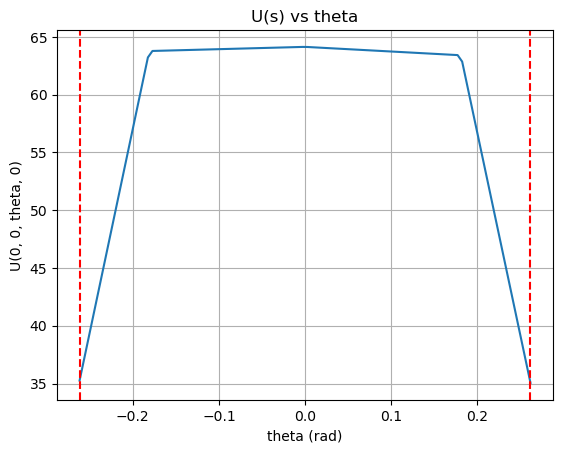

In [441]:
thetha_linspace = np.linspace(-THETA_THRESH, THETA_THRESH, 100)
U_example = np.zeros((100))
for i, thetha_i in enumerate(thetha_linspace):
    U_example[i] = U_parametrized_general((0, 0, thetha_i, 0), params)

fig, ax = plt.subplots()
ax.plot(thetha_linspace, U_example)
ax.axvline(x=THETA_THRESH, color='r', linestyle='--')
ax.axvline(x=-THETA_THRESH, color='r', linestyle='--')
ax.set_xlabel('theta (rad)')
ax.set_ylabel('U(0, 0, theta, 0)')
ax.set_title('U(s) vs theta')
ax.grid()
plt.show()

##### 2.3.2. Greedy Policy

In [442]:
actions = [-1, 0, 1]
def look_ahead_funct(TR_funct, gamma, U_funct, s, a):
    s_next, r = TR_funct(s, a)
    return r + gamma * U_funct(s_next, params)

def greedy_funct(TR_funct, gamma, U_funct, s):
    a = actions[np.argmax([look_ahead_funct(TR_funct, gamma, U_funct, s, actions[a]) for a in range(n_actions)])]
    return a

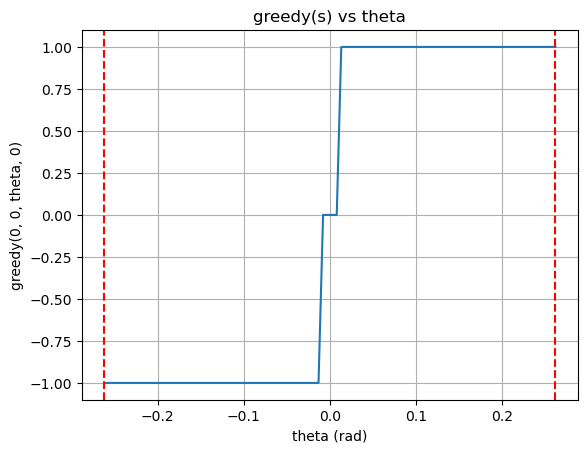

In [443]:
thetha_linspace = np.linspace(-THETA_THRESH, THETA_THRESH, 100)
actions_saved = np.ones((100))
for i, thetha_i in enumerate(thetha_linspace):
    actions_saved[i] = greedy_funct(simulate, gamma, U_parametrized_general, (0, 0, thetha_i, 0))

fig, ax = plt.subplots()
ax.plot(thetha_linspace, actions_saved)
ax.axvline(x=THETA_THRESH, color='r', linestyle='--')
ax.axvline(x=-THETA_THRESH, color='r', linestyle='--')
ax.set_xlabel('theta (rad)')
ax.set_ylabel('greedy(0, 0, theta, 0)')
ax.set_title('greedy(s) vs theta')
ax.grid()
plt.show()